In [3]:
import numpy as np
import dedalus.public as d3
import logging
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pathlib
import subprocess
import h5py

In [4]:
"""
Dedalus script simulating 2D horizontally-periodic Rayleigh-Benard convection.
This script demonstrates solving a 2D Cartesian initial value problem. It can
be ran serially or in parallel, and uses the built-in analysis framework to save
data snapshots to HDF5 files. The `plot_snapshots.py` script can be used to
produce plots from the saved data. It should take about 5 cpu-minutes to run.

The problem is non-dimensionalized using the box height and freefall time, so
the resulting thermal diffusivity and viscosity are related to the Prandtl
and Rayleigh numbers as:

    kappa = (Rayleigh * Prandtl)**(-1/2)
    nu = (Rayleigh / Prandtl)**(-1/2)

For incompressible hydro with two boundaries, we need two tau terms for each the
velocity and buoyancy. Here we choose to use a first-order formulation, putting
one tau term each on auxiliary first-order gradient variables and the others in
the PDE, and lifting them all to the first derivative basis. This formulation puts
a tau term in the divergence constraint, as required for this geometry.

To run and plot using e.g. 4 processes:
    $ mpiexec -n 4 python3 rayleigh_benard.py
    $ mpiexec -n 4 python3 plot_snapshots.py snapshots/*.h5
"""

logger = logging.getLogger(__name__)


# Parameters
Lx, Lz = 4, 1
Nx, Nz = 256, 64
Rayleigh = 2e6
Prandtl = 1
dealias = 3/2
stop_sim_time = 4
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
b = dist.Field(name='b', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
tau_p = dist.Field(name='tau_p')
tau_b1 = dist.Field(name='tau_b1', bases=xbasis)
tau_b2 = dist.Field(name='tau_b2', bases=xbasis)
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)

# Substitutions
kappa = (Rayleigh * Prandtl)**(-1/2)
nu = (Rayleigh / Prandtl)**(-1/2)
x, z = dist.local_grids(xbasis, zbasis)
ex, ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
grad_b = d3.grad(b) + ez*lift(tau_b1) # First-order reduction

# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, b, u, tau_p, tau_b1, tau_b2, tau_u1, tau_u2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("dt(b) - kappa*div(grad_b) + lift(tau_b2) = - u@grad(b)")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p) - b*ez + lift(tau_u2) = - u@grad(u)")
problem.add_equation("b(z=0) = Lz")
problem.add_equation("u(z=0) = 0")
problem.add_equation("b(z=Lz) = 0")
problem.add_equation("u(z=Lz) = 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Initial conditions
b.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
b['g'] *= z * (Lz - z) # Damp noise at walls
b['g'] += Lz - z # Add linear background

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=0.25, max_writes=50)
snapshots.add_task(b, name='buoyancy')
snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')
avgb= solver.evaluator.add_file_handler('avgb', sim_dt=0.01)
avgb.add_task(d3.Average(b,('x',)), name='average buoyancy')

# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')

# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            #logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()


2023-05-25 16:40:33,389 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 14s, Rate: 9.0e+00/s
2023-05-25 16:40:34,050 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 1s, Remaining: 7s, Rate: 1.7e+01/s
2023-05-25 16:40:34,770 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 1s, Remaining: 6s, Rate: 1.7e+01/s
2023-05-25 16:40:35,481 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 2s, Remaining: 5s, Rate: 1.8e+01/s
2023-05-25 16:40:36,193 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 3s, Remaining: 4s, Rate: 1.8e+01/s
2023-05-25 16:40:36,900 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 4s, Remaining: 4s, Rate: 1.8e+01/s
2023-05-25 16:40:37,606 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 4s, Remaining: 3s, Rate: 1.8e+01/s
2023-05-25 16:40:38,373 subsystems 0/1 INFO :: Building subprob

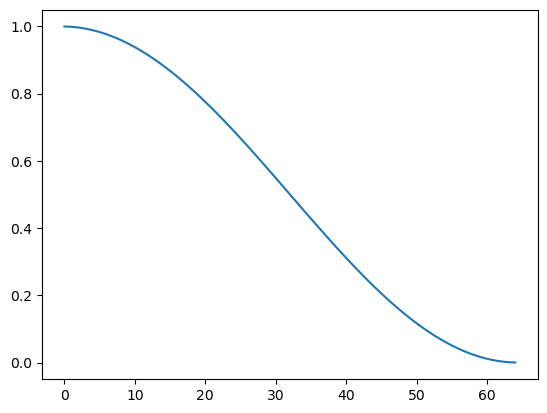

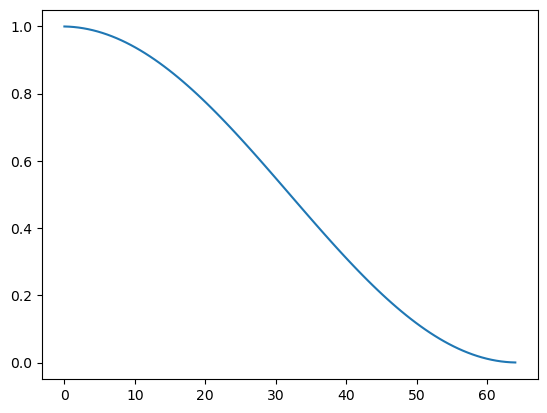

In [5]:
# shows that buoyancy is only determined by height and not x
maximum=np.max(b.evaluate()['g'],axis=0)
z=np.linspace(0,Nz,int(3*Nz/2))
plt.plot(z,maximum)
plt.show()

avg=d3.Average(b,('x',)).evaluate()['g'].reshape(d3.Average(b,('x',)).evaluate()['g'].size)
z=np.linspace(0,Nz,int(3*Nz/2))
plt.plot(z,avg)
plt.show()

In [6]:
print(subprocess.check_output("find snapshots | sort", shell=True).decode())

snapshots
snapshots/snapshots_s1.h5



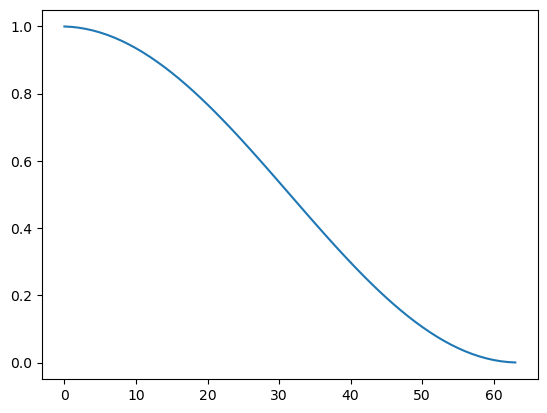

In [7]:
# chebyshev basis cause nonlinear? how to find the correct grid
# avg buoyancy over time, non-changing; apparently
with h5py.File('snapshots/snapshots_s1.h5', 'r') as file:
    buoyancy=file['tasks']['buoyancy'][:,:,:]
    avgb=np.mean(buoyancy,axis=1)
    plt.plot(np.arange(len(avgb[-1,:])),avgb[-1,:])
    plt.show()

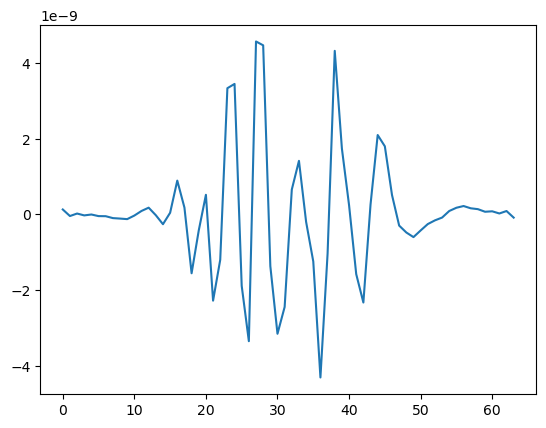

In [8]:
# avg vorticity over time, changing
with h5py.File('snapshots/snapshots_s1.h5', 'r') as file:
    vorticity=file['tasks']['vorticity'][:,:,:]
    avgv1=np.mean(vorticity,axis=1)
    plt.plot(np.arange(len(avgv1[2,:])),avgv1[2,:])
    plt.show()
   

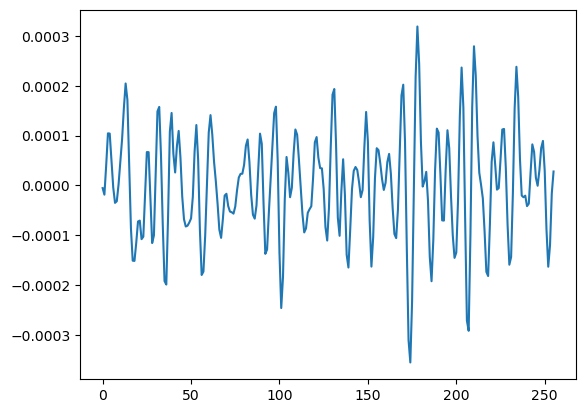

In [9]:
# avg vorticity over time, changing
with h5py.File('snapshots/snapshots_s1.h5', 'r') as file:
    vorticity=file['tasks']['vorticity'][:,:,:]
    avgv2=np.mean(vorticity,axis=2)
    plt.plot(np.arange(len(avgv2[2,:])),avgv2[2,:])
    plt.show()
   

In [10]:
# Avg vorticity(z) time animated
    
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

def update(frame):
    line.set_data(np.arange(len(avgv1[frame, :])), avgv1[frame, :])
    return line,

ax.set_xlim(0, len(avgv1[0, :]))
ax.set_ylim(np.min(avgv1), np.max(avgv1))

animation = FuncAnimation(fig, update, frames=len(avgv1), interval=200, blit=True)
animation.save('avg vorticity(z).gif', writer='imagemagick')

2023-05-25 16:40:58,138 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.ImageMagickWriter'>
2023-05-25 16:40:58,140 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: convert -size 640x480 -depth 8 -delay 20.0 -loop 0 rgba:- -layers OptimizePlus 'avg vorticity(z).gif'


In [11]:
# Avg vorticity(x) over time animated
    
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

def update(frame):
    line.set_data(np.arange(len(avgv2[frame, :])), avgv2[frame, :])
    return line,

ax.set_xlim(0, len(avgv2[0, :]))
ax.set_ylim(np.min(avgv2), np.max(avgv2))

animation = FuncAnimation(fig, update, frames=len(avgv2), interval=200, blit=True)
animation.save('avg vorticity(x).gif', writer='imagemagick')

2023-05-25 16:40:59,892 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.ImageMagickWriter'>
2023-05-25 16:40:59,893 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: convert -size 640x480 -depth 8 -delay 20.0 -loop 0 rgba:- -layers OptimizePlus 'avg vorticity(x).gif'


In [12]:
solver.log_stats()

2023-05-25 16:41:05,123 solvers 0/1 INFO :: Final iteration: 32
2023-05-25 16:41:05,124 solvers 0/1 INFO :: Final sim time: 4.0
2023-05-25 16:41:05,124 solvers 0/1 INFO :: Setup time (init - iter 0): 7.579 sec
2023-05-25 16:41:05,124 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.216 sec
2023-05-25 16:41:05,125 solvers 0/1 INFO :: Run time (iter 10-end): 23.05 sec
2023-05-25 16:41:05,125 solvers 0/1 INFO :: CPU time (iter 10-end): 0.006403 cpu-hr
2023-05-25 16:41:05,126 solvers 0/1 INFO :: Speed: 1.275e+05 mode-stages/cpu-sec


In [87]:
#run in cmd
"""

Plot 2D cartesian snapshots.

Usage:
    plot_snapshots.py <files>... [--output=<dir>]

Options:
    --output=<dir>  Output directory [default: ./frames]    
"""

import h5py
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from dedalus.extras import plot_tools


def main(filename, start, count, output):
    """Save plot of specified tasks for given range of analysis writes."""

    # Plot settings
    tasks = ['buoyancy', 'vorticity']
    scale = 1.5
    dpi = 200
    title_func = lambda sim_time: 't = {:.3f}'.format(sim_time)
    savename_func = lambda write: 'write_{:06}.png'.format(write)

    # Layout
    nrows, ncols = 2, 1
    image = plot_tools.Box(4, 1)
    pad = plot_tools.Frame(0.3, 0, 0, 0)
    margin = plot_tools.Frame(0.2, 0.1, 0, 0)

    # Create multifigure
    mfig = plot_tools.MultiFigure(nrows, ncols, image, pad, margin, scale)
    fig = mfig.figure

    # Plot writes
    with h5py.File(filename, mode='r') as file:
        for index in range(start, start+count):
            for n, task in enumerate(tasks):
                # Build subfigure axes
                i, j = divmod(n, ncols)
                axes = mfig.add_axes(i, j, [0, 0, 1, 1])
                # Call 3D plotting helper, slicing in time
                dset = file['tasks'][task]
                plot_tools.plot_bot_3d(dset, 0, index, axes=axes, title=task, even_scale=True, visible_axes=False)
            # Add time title
            title = title_func(file['scales/sim_time'][index])
            title_height = 1 - 0.5 * mfig.margin.top / mfig.fig.y
            fig.suptitle(title, x=0.44, y=title_height, ha='left')
            # Save figure
            savename = savename_func(file['scales/write_number'][index])
            savepath = output.joinpath(savename)
            fig.savefig(str(savepath), dpi=dpi)
            fig.clear()
    plt.close(fig)


if __name__ == "__main__":

    import pathlib
    from docopt import docopt
    from dedalus.tools import logging
    from dedalus.tools import post
    from dedalus.tools.parallel import Sync

    args = docopt(__doc__)

    output_path = pathlib.Path(args['--output']).absolute()
    # Create output directory if needed
    with Sync() as sync:
        if sync.comm.rank == 0:
            if not output_path.exists():
                output_path.mkdir()
    post.visit_writes(args['<files>'], main, output=output_path)


SyntaxError: invalid syntax (<ipython-input-87-749bc6491d4b>, line 23)